# Tests Unitaires pour l'algorithme génétique 

Ce jupyter notebook contient les tests unitaires de chacunes des fonctions de l'algorithme génétique écrit par SALEK Chada, ZARKUA Audrey et LAYOUS Alexandre. 

In [1]:
import os
import matplotlib.pyplot as plt
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import random

import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
import math

2024-04-06 11:24:19.800407: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-06 11:24:19.803782: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-06 11:24:19.844387: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-06 11:24:21.756399: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Importation du modèle

In [74]:
## sampling class
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        print("Batch used in the Sampling function")
        print(batch)
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 512 

## encodeur
encoder_inputs = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, 4, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = layers.Conv2D(64, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Conv2D(128, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
x = layers.Conv2D(256, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(latent_dim, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

## decodeur
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 256))(x)
x = layers.Conv2DTranspose(256, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, 4, activation="relu",strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


## class vae
@tf.keras.utils.register_keras_serializable()
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        # self.kl_list = []
        #self.reconstruction_list = []

    # def get_loss_list(self):
    #     return [self.kl_list]

    def get_config(self):
        #, "total_loss":self.total_loss_tracker,"reconstruction_loss" :self.reconstruction_loss_tracker, "kl_loss":self.kl_loss_tracker
        return {"encoder": self.encoder, "decoder":self.decoder}

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = tf.reduce_sum(tf.square(tf.exp(z_log_var)) + tf.square(z_mean) - z_log_var - 0.5, axis=1)
            total_loss =reconstruction_loss + kl_loss/2
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Batch used in the Sampling function
Tensor("strided_slice:0", shape=(), dtype=int32)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │      1,568 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │      9,248 │ conv2d_8[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │     32,832 │ conv2d_9[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │     36,928 │ conv2d_10[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 8, 8, 128) │    131,200 │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 8, 8, 128) │    147,584 │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 4, 4, 256) │    524,544 │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 4, 4, 256) │    590,080 │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4096)      │          0 │ conv2d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │  2,097,664 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 512)       │    262,656 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 512)       │    262,656 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 512)       │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,096,960 (15.63 MB)

 Trainable params: 4,096,960 (15.63 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 8, 8, 256)      │     1,048,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 16, 16, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 32, 32, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 64, 64, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 64, 64, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_15             │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,033,059 (15.38 MB)

 Trainable params: 4,033,059 (15.38 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
vae = VAE(encoder, decoder)
vae.load_weights('latent_dim_512_epoch_100_batch_64_data_30000_16_couches.weights.h5')

In [5]:
data_dir=os.path.join('celebA20faces')

batch_size=128
img_height= 64
img_width= 64

train_ds = tf.keras.utils.image_dataset_from_directory( data_dir,validation_split=0.2,subset="training",seed=123,image_size=(img_height, img_width),batch_size=batch_size, labels=None)

x_train_list = list(train_ds)
x_train=x_train_list[0]
x_train=x_train.numpy()
for element in x_train_list:
    element=element.numpy()
    x_train=np.concatenate([x_train, element], axis=0)
x_train = x_train.astype("float32") / 255

Found 20 files.
Using 16 files for training.


2024-04-06 11:27:38.513630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
z_mean,_,x_encoded = vae.encoder(x_train[:20])

Batch used in the Sampling function
tf.Tensor(20, shape=(), dtype=int32)


# Algorithme génétique

# 1) One point crossover : 

In [8]:
def one_point_crossover(parent1, parent2):
    
    """
        Applies one-point crossover to two parent arrays.

    A single crossover point is randomly selected on both parent arrays.
    Data beyond this crossover point is swapped between the parents to create two children.

    Args:
        parent1 (array-like): The first parent array.
        parent2 (array-like): The second parent array.

    Returns:
        numpy.ndarray: An array representing the first child.
    """
   
    parent1_tensor = tf.constant(parent1)
    parent2_tensor = tf.constant(parent2)

    child1 = tf.TensorArray(dtype=parent1_tensor.dtype, size=tf.size(parent1_tensor))

    departure_point = random.randint(0, tf.size(parent1_tensor))


    for i in range(departure_point):
        child1 = child1.write(i, parent1_tensor[i])

    for i in range(departure_point, tf.size(parent2_tensor)):
        child1 = child1.write(i, parent2_tensor[i])

    return child1.stack()


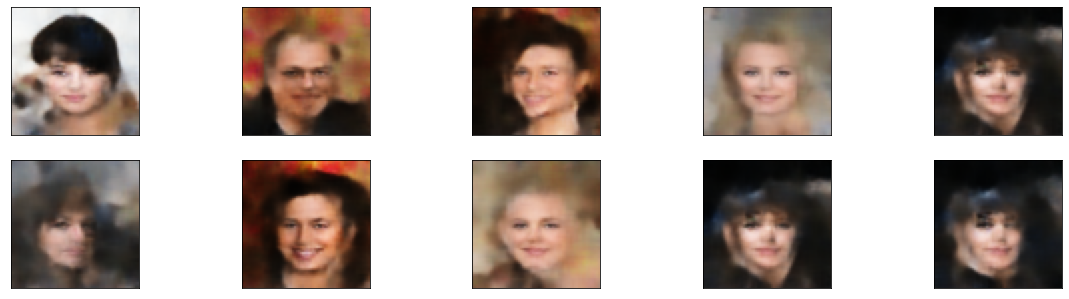

In [31]:
x_1_crossover = []
for i in range(10): 
    x_1_crossover.append(one_point_crossover(x_encoded[i], x_encoded[i+1]))
    
x_to_decode = tf.stack(x_1_crossover, axis=0) 

x = vae.decoder(x_encoded)
x_decoded_1 = vae.decoder(x_to_decode)

n = 5
plt.figure(figsize=(20, 8))
for i in range(n):
    # Afficher les images originales
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Afficher les images reconstruites
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_decoded_1[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
plt.show()


# 2 ) Multiple points crossover (par bloc et par points) : 

In [37]:
def several_points_crossover(parent1, parent2, number_points):
    
    """
    Applies several points crossover to two parent arrays.

    Multiple crossover points are randomly selected on both parent arrays.
    Data beyond each crossover point is swapped between the parents to create two children.

    Args:
        parent1 (array-like): The first parent array.
        parent2 (array-like): The second parent array.
        number_points (int): The number of crossover points.

    Returns:
        numpy.ndarray: An array representing the first child.

    """
   
    # Créer des tenseurs pour les parents
    parent1_tensor = tf.constant(parent1)
    parent2_tensor = tf.constant(parent2)

    child1 = tf.TensorArray(dtype=parent1_tensor.dtype, size=len(parent1))
    child2 = tf.TensorArray(dtype=parent1_tensor.dtype, size=len(parent1))

    # Choisir aléatoirement les points de croisement
    points = sorted(random.sample(range(1, len(parent1)), number_points))

    parent_iter = iter((parent2_tensor, parent1_tensor,parent2_tensor, parent1_tensor, parent2_tensor, parent1_tensor, parent2_tensor,parent1_tensor, parent2_tensor, parent1_tensor))

    current_parent = parent1_tensor

    for i, gene in enumerate(parent1_tensor):
        if i in points:
            current_parent = next(parent_iter)
            
        child1 = child1.write(i, gene if tf.reduce_all(tf.math.equal(current_parent, parent1_tensor)) else tf.gather(parent2_tensor, i))
        child2 =  child2.write(i, tf.gather(parent2_tensor, i) if tf.reduce_all(tf.math.equal(current_parent, parent1_tensor)) else gene)


    return child1.stack()

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)  File "/tmp/ipykernel_10674/1493454165.py", line 3, in <module>
    x_2_crossover.append(several_points_crossover(x_encoded[i], x_encoded[i+1], 7))  File "/tmp/ipykernel_10674/1123745597.py", line 32, in several_points_crossover
    return child1.stack()  File "/home/csalek/.local/lib/python3.10/site-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
ERROR:tensorflow:=======

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)  File "/tmp/ipykernel_10674/1493454165.py", line 3, in <module>
    x_2_crossover.append(several_points_crossover(x_encoded[i], x_encoded[i+1], 7))  File "/tmp/ipykernel_10674/1123745597.py", line 32, in several_points_crossover
    return child1.stack()  File "/home/csalek/.local/lib/python3.10/site-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
ERROR:tensorflow:=======

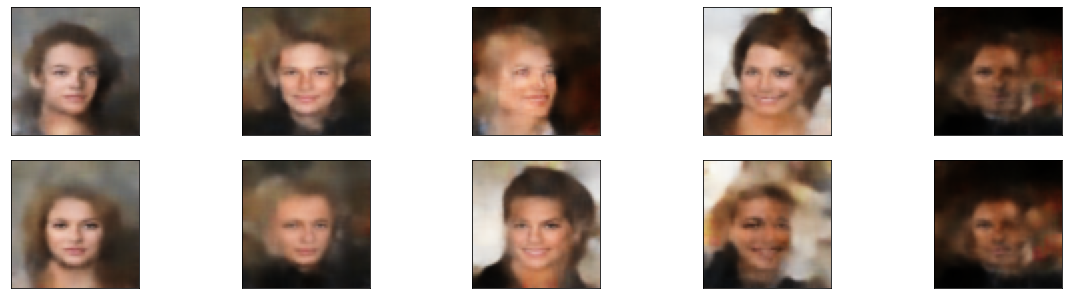

In [38]:
x_2_crossover = []
for i in range(10): 
    x_2_crossover.append(several_points_crossover(x_encoded[i], x_encoded[i+1], 7))
    
x_to_decode = tf.stack(x_2_crossover, axis=0) 

x = vae.decoder(x_encoded)
x_decoded_1 = vae.decoder(x_to_decode)

n = 5
plt.figure(figsize=(20, 8))
for i in range(n,10):
    # Afficher les images originales
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Afficher les images reconstruites
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_decoded_1[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
plt.show()


In [39]:
def several_points_crossover_v2(parent1, parent2):
    """
    Applies several points crossover to two parent arrays.

    For each index in the parent arrays, a random choice is made between the corresponding elements of
    the parents based on a randomly generated sequence of 1s and 2s.

    Args:
        parent1 (tf.Tensor): The first parent array.
        parent2 (tf.Tensor): The second parent array.

    Returns:
        list: A list representing the child array generated from crossover.

    """

    p1 = parent1.numpy()
    p2 = parent2.numpy()
    child = []
    where = [random.randint(1, 2) for _ in range(len(p1))]

    for i in range(len(p1)):
        if where[i]==1 :
            child.append(p1[i])
        else :
            child.append(p2[i])
    return child


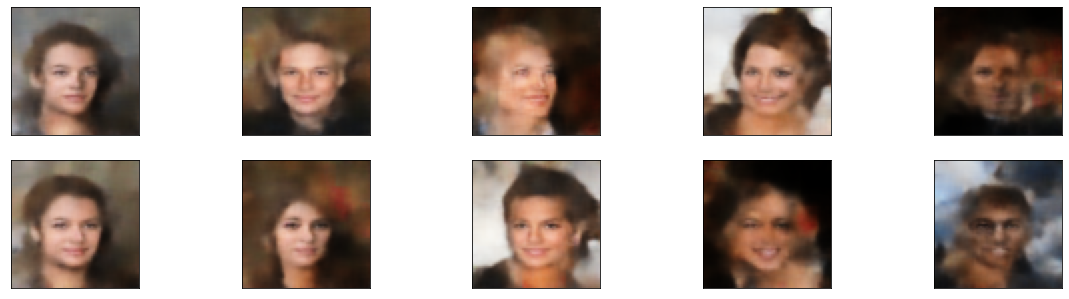

In [40]:
x_2_crossover = []
for i in range(10): 
    x_2_crossover.append(several_points_crossover_v2(x_encoded[i], x_encoded[i+1]))

x_to_decode = tf.stack(x_2_crossover, axis=0) 

x = vae.decoder(x_encoded)
x_decoded_1 = vae.decoder(x_to_decode)

n = 5
plt.figure(figsize=(20, 8))
for i in range(n,10):
    # Afficher les images originales
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Afficher les images reconstruites
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_decoded_1[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
plt.show()

# 3)  Bruit Gaussien : 

In [41]:
def gaussian_noise_1(parent, mean, std, n):
    """
        Applies Gaussian noise to randomly selected points on both parent arrays.

    Args:
        parent (np.ndarray): Array representing the parent.
        mean (float): Mean of the Gaussian noise distribution.
        std (float): Standard deviation of the Gaussian noise distribution.
        n (int): Number of points to be randomly selected on each parent array.

    Returns:
        np.ndarray: Array representing the first child.

    """

    p = parent.numpy()
    noise = np.random.normal(mean, std, len(p))
    points = sorted(random.sample(range(len(p)), n))
    child = p[:]

    for i in range(len(p)):
        if i in points:
            child[i] += noise[i]
    return child

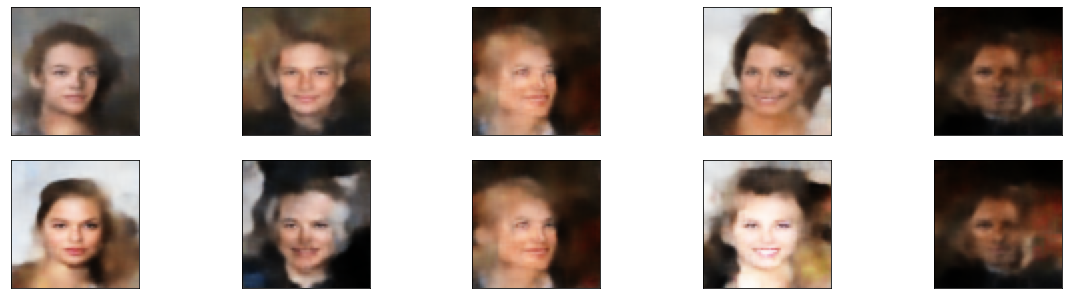

In [50]:
x_gaussian = []
for i in range(10): 
    x_gaussian.append(gaussian_noise_1(x_encoded[i], 0, 4, 30))

x_to_decode = tf.stack(x_gaussian, axis=0) 

x = vae.decoder(x_encoded)
x_decoded_1 = vae.decoder(x_to_decode)

n = 5
plt.figure(figsize=(20, 8))
for i in range(n,10):
    # Afficher les images originales
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Afficher les images reconstruites
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_decoded_1[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
plt.show()

# 4 ) Moyennes :

In [51]:
def mean_parents(parent1, parent2):
    """
     Compute the mean of the values of two parent arrays.

    Args:
        parent1 (np.ndarray): The first parent array.
        parent2 (np.ndarray): The second parent array.

    Returns:
        np.ndarray: An array representing the child with values equal to the mean of the values
                   of the corresponding parents.
    """


    p1 = parent1.numpy()
    p2 = parent2.numpy()
    child = []

    for i in range(len(p1)):
        child.append((p1[i]+p2[i])/2)

    return child

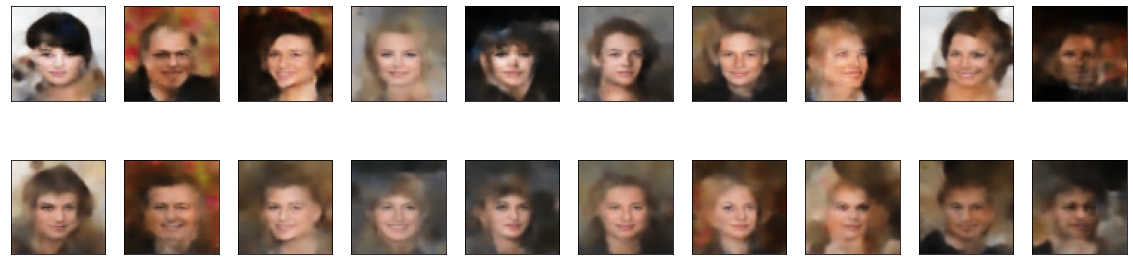

In [59]:
x_moyen = []
for i in range(10): 
    x_moyen.append(mean_parents(x_encoded[i], x_encoded[i+1]))
    
x_to_decode = tf.stack(x_moyen, axis=0) 

x = vae.decoder(x_encoded)
x_decoded_1 = vae.decoder(x_to_decode)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    # Afficher les images originales
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Afficher les images reconstruites
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_decoded_1[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
plt.show()

# Fonctions finales : 

Ces fonctions regroupent toutes les méthodes (mutation et crossover) vues plus haut afin de fournir à l'utilisateur plusieurs visages ressemblants. 

In [20]:

def one_selection(parent, std, m):
    """
   Introduces Gaussian noise to the selected parent vector for decoding.

    Args:
        parent (np.ndarray): The encoded vector of the selected parent.
        std (float): Standard deviation of the Gaussian noise.
        m (float): Mean of the Gaussian noise.

    Returns:
        np.ndarray: A stack of 4 output vectors, each containing Gaussian noise introduced for decoding.

    Note:
   """

    output1 = gaussian_noise_1(parent, m, std+1, 30)
    output2 = gaussian_noise_1(parent, m, std+2, 35)/2
    output3 = gaussian_noise_1(parent, m, std+3, 35)/5
    output4 = gaussian_noise_1(parent, m, std+4, 30)/3

    x_modified = []
    x_modified.append(output1)
    x_modified.append(output2)
    x_modified.append(output3)
    x_modified.append(output4)

    x_to_decode = tf.stack(x_modified, axis = 0)

    return x_to_decode

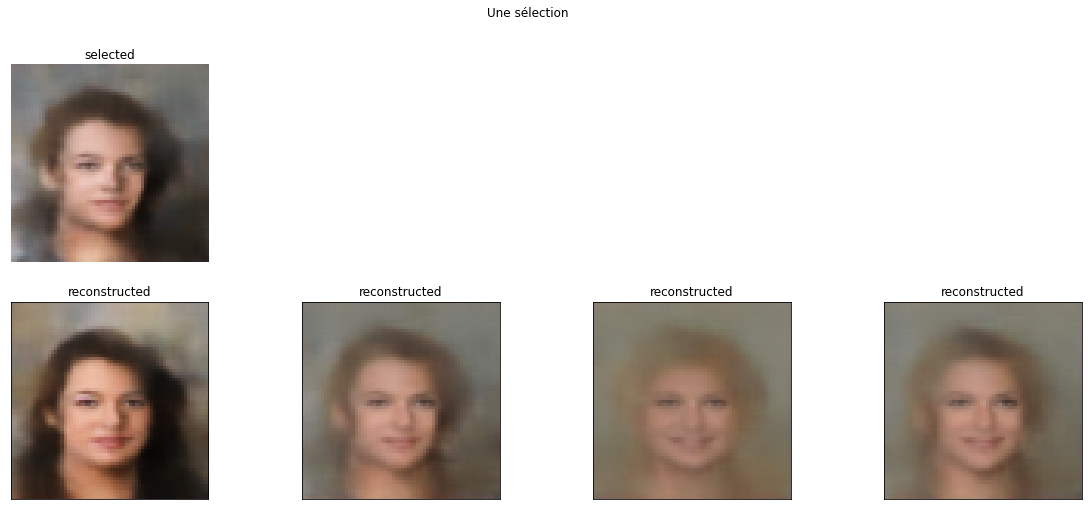

In [61]:
x_1 = one_selection(x_encoded[5], 0, 2)


x_decoded = vae.decoder(x_encoded)
x_decoded2 = vae.decoder(x_1)

plt.figure(figsize=(20, 8))

plt.subplot(2, 4, 1)
plt.title("selected")
plt.imshow(x_decoded[5])
plt.axis('off')


for i in range(4):
    # display reconstruction
    bx = plt.subplot(2, 4, i + 5)
    plt.title("reconstructed")
    plt.imshow(x_decoded2[i])
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.suptitle('Une sélection')
plt.show()


In [62]:
def two_selections(parent1, parent2):
    """
    Introduces genetic operations to two selected parents for decoding.

    Args:
        parent1 (tf.Tensor): The first parent array.
        parent2 (tf.Tensor): The second parent array.

    Returns:
        tf.Tensor: A stack of 4 output tensors, each representing a genetic operation applied to the parents.

    """

    output1 = several_points_crossover_v2(parent1, parent2)
    output2 = one_point_crossover(parent1, parent2)
    output3 = mean_parents(parent1, parent2)
    output4 = several_points_crossover(parent1,parent2, 7)

    x_modified = []
    x_modified.append(output1)
    x_modified.append(output2)
    x_modified.append(output3)
    x_modified.append(output4)

    x_to_decode = tf.stack(x_modified, axis = 0)

    return x_to_decode


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3477, in run_code
    return outflag  File "/tmp/ipykernel_10674/713729938.py", line 1, in <module>
    x_2 = two_selections(x_encoded[7], x_encoded[11])  File "/tmp/ipykernel_10674/2011818112.py", line 16, in two_selections
    return x_to_decode  File "/tmp/ipykernel_10674/1123745597.py", line 32, in several_points_crossover
    return child1.stack()  File "/home/csalek/.local/lib/python3.10/site-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


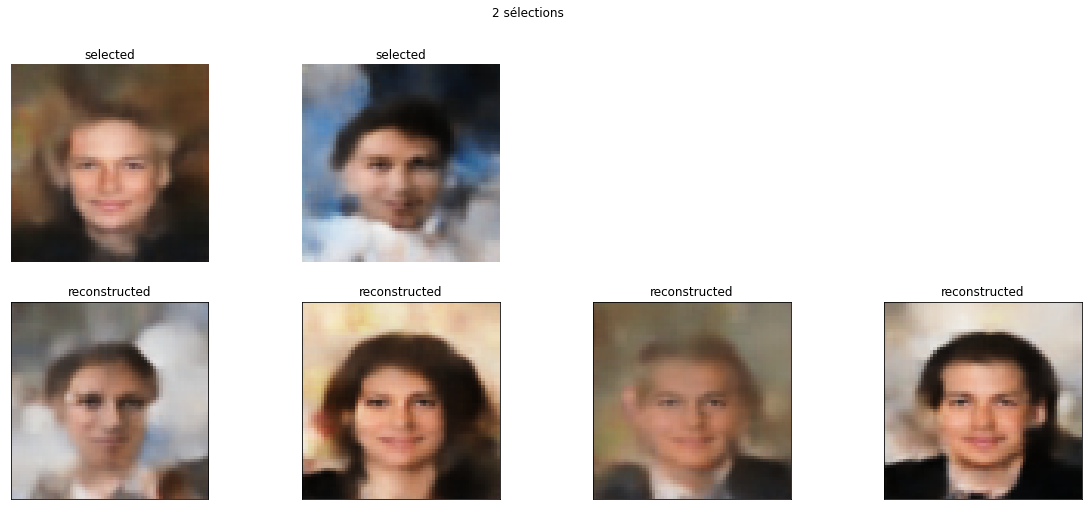

In [63]:
x_2 = two_selections(x_encoded[7], x_encoded[11])

x_decoded21 = vae.decoder(x_2)

plt.figure(figsize=(20, 8))

plt.subplot(2, 4, 1)
plt.title("selected")
plt.imshow(x_decoded[6])
plt.axis('off')
plt.subplot(2, 4, 2)
plt.title("selected")
plt.imshow(x_decoded[10])
plt.axis('off')

for i in range(4):

    # display reconstruction
    bx = plt.subplot(2, 4, i + 5)
    plt.title("reconstructed")
    plt.imshow(x_decoded21[i])
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.suptitle('2 sélections')
plt.show()


In [65]:
def multiple_selections(*parents):
       """
    Introduces genetic operations to multiple selected parents for decoding.

    Applies several genetic operations, including crossover and mutation, to pairs of selected parents.
    From each pair of parents, four outputs are generated using different genetic operations.
    Then, three outputs are randomly selected from all generated outputs, and the mean of all parents is calculated.
    The selected outputs and the mean of parents are stacked together for decoding.

    Args:
        *parents: Variable number of parent arrays.

    Returns:
        tf.Tensor: A stack of selected output tensors and the mean of all parent tensors.

    Note:
        This function assumes that all 'parents' are TensorFlow tensors.
    """

    outputs = []

    for parent1, parent2 in zip(parents[:-1], parents[1:]):
        output1 = several_points_crossover_v2(parent1, parent2)
        output2 = one_point_crossover(parent1, parent2)
        output3 = mean_parents(parent1, parent2)
        output4 = several_points_crossover(parent1, parent2, 7)

        outputs.extend([output1, output2, output3, output4])

    # Sélectionner 3 éléments aléatoires de la liste 'outputs' + moyenne de tous les parents
    selected_outputs = random.sample(outputs, 3)
    selected_outputs.append(mean_parents1(*parents))


    x_to_decode = tf.stack(selected_outputs, axis=0)

    return x_to_decode


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)  File "/tmp/ipykernel_10674/597877021.py", line 1, in <module>
    x_3 = multiple_selections( x_encoded[13], x_encoded[6], x_encoded[12])  File "/tmp/ipykernel_10674/1189069609.py", line 7, in multiple_selections
    output2 = one_point_crossover(parent1, parent2)  File "/tmp/ipykernel_10674/1123745597.py", line 32, in several_points_crossover
    return child1.stack()  File "/home/csalek/.local/lib/python3.10/site-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
ERROR:tensorflow:==================================
Object was ne

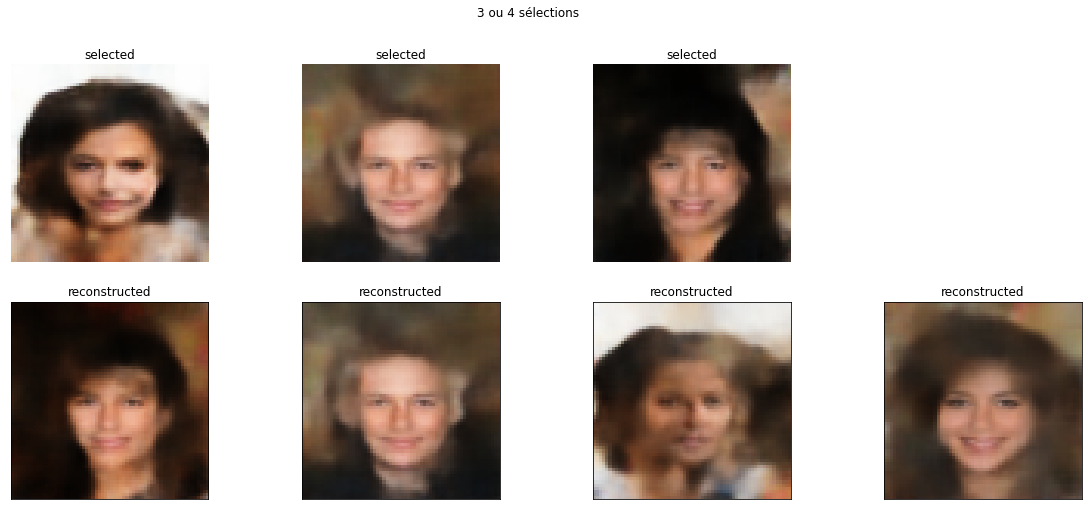

In [73]:
x_3 = multiple_selections( x_encoded[13], x_encoded[6], x_encoded[12])

x_decoded22 = vae.decoder(x_3)

plt.figure(figsize=(20, 8))

plt.subplot(2, 4, 1)
plt.title("selected")
plt.imshow(x_decoded[13])
plt.axis('off')
plt.subplot(2, 4, 2)
plt.title("selected")
plt.imshow(x_decoded[6])
plt.axis('off')
plt.subplot(2, 4, 3)
plt.title("selected")
plt.imshow(x_decoded[12])
plt.axis('off')

for i in range(4):
    # display reconstruction
    bx = plt.subplot(2, 4, i + 5)
    plt.title("reconstructed")
    plt.imshow(x_decoded22[i])
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.suptitle('3 ou 4 sélections')
plt.show()